In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.cross_validation import H2OKFold
from h2o.model.regression import h2o_r2_score
from h2o.model.metrics_base import H2OBinomialModelMetrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from h2o.model.regression import h2o_mean_squared_error
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

In [2]:
# open the cleaned csv file from data prep and variable extraction
df = pd.read_csv('pred_ready.csv')

# open the outcomes from the original dataset
outcomes = pd.read_csv('outcomes_a.csv')

# drop the extra column from each
df.drop('Unnamed: 0', axis=1, inplace=True)
outcomes.drop('Unnamed: 0', axis=1, inplace=True)

# set outcomes as series y
y = outcomes['In-hospital_death']

# adjust outcomes for to 'survived' and in-hospital-death ('IHD')
survival = []
for x in y:
    if x == 0:
        survival.append('SURVIVED')
    if x == 1:
        survival.append('IHD')

y = pd.DataFrame(survival, columns=['In-hospital_death'])

y.head(10)

,In-hospital_death
0,SURVIVED
1,SURVIVED
2,SURVIVED
3,SURVIVED
4,SURVIVED
5,SURVIVED
6,SURVIVED
7,IHD
8,SURVIVED
9,SURVIVED


## Scikit-learn
#### Imputing values and baseline random forest

In [3]:
# impute means for random forest classifier
# standardize data using standard scaler
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler = StandardScaler()
df1 = imp_mean.fit_transform(df.drop('RecordID', axis=1))
df1_ = scaler.fit_transform(df1)
# use sklearn's train test split to have train and validation set
X_train, X_test, y_train, y_test = train_test_split(df1_, y, test_size=0.25,
                                                   random_state=42)

# create random forest classifier
ranfor = RandomForestClassifier(random_state=42)

# fit classifier and predict on dataset
ranfor.fit(X_train, y_train)
y_pred = ranfor.predict(X_test)

# get accuracy score for predictions
acc = metrics.accuracy_score(y_test, y_pred)
acc

/Users/manny/opt/anaconda3/envs/py3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/manny/opt/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


0.865

## H2O
#### Data munging

In [4]:
# h2o.init to initiate h2o

h2o.init()

# we'll need column headers after converting pandas df to h2o df
# upload pred_ready file and outcomes
df_h2o = h2o.upload_file('pred_ready.csv')
print(df_h2o.shape)
oc_h2o = h2o.upload_file('outcomes_a.csv')

# see how imbalanced label class is
print(oc_h2o['In-hospital_death'].table())

# percentage-wise imbalance:
n = df_h2o.shape[0]
print(oc_h2o['In-hospital_death'].table()['Count'] / n)

# set up labels column
y_h2o = oc_h2o['In-hospital_death']
print(y_h2o)

# set up predictors dataframe
# drop the RecordID column and initial index column
X = df_h2o.drop([0,1])
print(X)

# get column headers from X to use as labels for dataframe
x_n = X.columns

# create dataframe from df1 with imputed means, then correct headers
df2 = h2o.H2OFrame(df1_)
df2.columns=x_n
print(df2)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,13 days 11 hours 23 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,"3 years, 10 months and 15 days !!!"
H2O cluster name:,H2O_from_python_manny_wvr5yu
H2O cluster total nodes:,1
H2O cluster free memory:,1.379 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
(4000, 340)
Parse progress: |█████████████████████████████████████████████████████████| 100%


In-hospital_death,Count
0,3446
1,554


Count
0.8615
0.1385


In-hospital_death
0
0
0
0
0
0
0
1
0
0


Age,Gender,Height,ICUType,Weight,ALP_first,ALP_last,ALP_min,ALP_max,ALP_q1,ALP_median,ALP_q3,ALP_mean,ALP_count,ALT_first,ALT_last,ALT_min,ALT_max,ALT_q1,ALT_median,ALT_q3,ALT_mean,ALT_count,AST_first,AST_last,AST_min,AST_max,AST_q1,AST_median,AST_q3,AST_mean,AST_count,Albumin_first,Albumin_last,Albumin_min,Albumin_max,Albumin_q1,Albumin_median,Albumin_q3,Albumin_mean,Albumin_count,BUN_first,BUN_last,BUN_min,BUN_max,BUN_q1,BUN_median,BUN_q3,BUN_mean,BUN_count,Bilirubin_first,Bilirubin_last,Bilirubin_min,Bilirubin_max,Bilirubin_q1,Bilirubin_median,Bilirubin_q3,Bilirubin_mean,Bilirubin_count,Cholesterol_first,Cholesterol_last,Cholesterol_min,Cholesterol_max,Cholesterol_q1,Cholesterol_median,Cholesterol_q3,Cholesterol_mean,Cholesterol_count,Creatinine_first,Creatinine_last,Creatinine_min,Creatinine_max,Creatinine_q1,Creatinine_median,Creatinine_q3,Creatinine_mean,Creatinine_count,DiasABP_first,DiasABP_last,DiasABP_min,DiasABP_max,DiasABP_q1,DiasABP_median,DiasABP_q3,DiasABP_mean,DiasABP_count,FiO2_first,FiO2_last,FiO2_min,FiO2_max,FiO2_q1,FiO2_median,FiO2_q3,FiO2_mean,FiO2_count,GCS_first,GCS_last,GCS_min,GCS_max,GCS_q1,GCS_median,GCS_q3,GCS_mean,GCS_count,Glucose_first,Glucose_last,Glucose_min,Glucose_max,Glucose_q1,Glucose_median,Glucose_q3,Glucose_mean,Glucose_count,HCO3_first,HCO3_last,HCO3_min,HCO3_max,HCO3_q1,HCO3_median,HCO3_q3,HCO3_mean,HCO3_count,HCT_first,HCT_last,HCT_min,HCT_max,HCT_q1,HCT_median,HCT_q3,HCT_mean,HCT_count,HR_first,HR_last,HR_min,HR_max,HR_q1,HR_median,HR_q3,HR_mean,HR_count,K_first,K_last,K_min,K_max,K_q1,K_median,K_q3,K_mean,K_count,Lactate_first,Lactate_last,Lactate_min,Lactate_max,Lactate_q1,Lactate_median,Lactate_q3,Lactate_mean,Lactate_count,MAP_first,MAP_last,MAP_min,MAP_max,MAP_q1,MAP_median,MAP_q3,MAP_mean,MAP_count,MechVent_first,MechVent_last,MechVent_min,MechVent_max,MechVent_q1,MechVent_median,MechVent_q3,MechVent_mean,MechVent_count,Mg_first,Mg_last,Mg_min,Mg_max,Mg_q1,Mg_median,Mg_q3,Mg_mean,Mg_count,NIDiasABP_first,NIDiasABP_last,NIDiasABP_min,NIDiasABP_max,NIDiasABP_q1,NIDiasABP_median,NIDiasABP_q3,NIDiasABP_mean,NIDiasABP_count,NIMAP_first,NIMAP_last,NIMAP_min,NIMAP_max,NIMAP_q1,NIMAP_median,NIMAP_q3,NIMAP_mean,NIMAP_count,NISysABP_first,NISysABP_last,NISysABP_min,NISysABP_max,NISysABP_q1,NISysABP_median,NISysABP_q3,NISysABP_mean,NISysABP_count,Na_first,Na_last,Na_min,Na_max,Na_q1,Na_median,Na_q3,Na_mean,Na_count,PaCO2_first,PaCO2_last,PaCO2_min,PaCO2_max,PaCO2_q1,PaCO2_median,PaCO2_q3,PaCO2_mean,PaCO2_count,PaO2_first,PaO2_last,PaO2_min,PaO2_max,PaO2_q1,PaO2_median,PaO2_q3,PaO2_mean,PaO2_count,Platelets_first,Platelets_last,Platelets_min,Platelets_max,Platelets_q1,Platelets_median,Platelets_q3,Platelets_mean,Platelets_count,RespRate_first,RespRate_last,RespRate_min,RespRate_max,RespRate_q1,RespRate_median,RespRate_q3,RespRate_mean,RespRate_count,SaO2_first,SaO2_last,SaO2_min,SaO2_max,SaO2_q1,SaO2_median,SaO2_q3,SaO2_mean,SaO2_count,SysABP_first,SysABP_last,SysABP_min,SysABP_max,SysABP_q1,SysABP_median,SysABP_q3,SysABP_mean,SysABP_count,Temp_first,Temp_last,Temp_min,Temp_max,Temp_q1,Temp_median,Temp_q3,Temp_mean,Temp_count,TroponinI_first,TroponinI_last,TroponinI_min,TroponinI_max,TroponinI_q1,TroponinI_median,TroponinI_q3,TroponinI_mean,TroponinI_count,TroponinT_first,TroponinT_last,TroponinT_min,TroponinT_max,TroponinT_q1,TroponinT_median,TroponinT_q3,TroponinT_mean,TroponinT_count,Urine_first,Urine_last,Urine_min,Urine_max,Urine_q1,Urine_median,Urine_q3,Urine_mean,Urine_count,WBC_first,WBC_last,WBC_min,WBC_max,WBC_q1,WBC_median,WBC_q3,WBC_mean,WBC_count,Weight_first,Weight_last,Weight_min,Weight_max,Weight_q1,Weight_median,Weight_q3,Weight_mean,Weight_count,pH_first,pH_last,pH_min,pH_max,pH_q1,pH_median,pH_q3,pH_mean,pH_count
54,0,169.9,4,82,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,13,8,8,13,9.25,10.5,11.75,10.5,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,


Parse progress: |█████████████████████████████████████████████████████████| 100%


Age,Gender,Height,ICUType,Weight,ALP_first,ALP_last,ALP_min,ALP_max,ALP_q1,ALP_median,ALP_q3,ALP_mean,ALP_count,ALT_first,ALT_last,ALT_min,ALT_max,ALT_q1,ALT_median,ALT_q3,ALT_mean,ALT_count,AST_first,AST_last,AST_min,AST_max,AST_q1,AST_median,AST_q3,AST_mean,AST_count,Albumin_first,Albumin_last,Albumin_min,Albumin_max,Albumin_q1,Albumin_median,Albumin_q3,Albumin_mean,Albumin_count,BUN_first,BUN_last,BUN_min,BUN_max,BUN_q1,BUN_median,BUN_q3,BUN_mean,BUN_count,Bilirubin_first,Bilirubin_last,Bilirubin_min,Bilirubin_max,Bilirubin_q1,Bilirubin_median,Bilirubin_q3,Bilirubin_mean,Bilirubin_count,Cholesterol_first,Cholesterol_last,Cholesterol_min,Cholesterol_max,Cholesterol_q1,Cholesterol_median,Cholesterol_q3,Cholesterol_mean,Cholesterol_count,Creatinine_first,Creatinine_last,Creatinine_min,Creatinine_max,Creatinine_q1,Creatinine_median,Creatinine_q3,Creatinine_mean,Creatinine_count,DiasABP_first,DiasABP_last,DiasABP_min,DiasABP_max,DiasABP_q1,DiasABP_median,DiasABP_q3,DiasABP_mean,DiasABP_count,FiO2_first,FiO2_last,FiO2_min,FiO2_max,FiO2_q1,FiO2_median,FiO2_q3,FiO2_mean,FiO2_count,GCS_first,GCS_last,GCS_min,GCS_max,GCS_q1,GCS_median,GCS_q3,GCS_mean,GCS_count,Glucose_first,Glucose_last,Glucose_min,Glucose_max,Glucose_q1,Glucose_median,Glucose_q3,Glucose_mean,Glucose_count,HCO3_first,HCO3_last,HCO3_min,HCO3_max,HCO3_q1,HCO3_median,HCO3_q3,HCO3_mean,HCO3_count,HCT_first,HCT_last,HCT_min,HCT_max,HCT_q1,HCT_median,HCT_q3,HCT_mean,HCT_count,HR_first,HR_last,HR_min,HR_max,HR_q1,HR_median,HR_q3,HR_mean,HR_count,K_first,K_last,K_min,K_max,K_q1,K_median,K_q3,K_mean,K_count,Lactate_first,Lactate_last,Lactate_min,Lactate_max,Lactate_q1,Lactate_median,Lactate_q3,Lactate_mean,Lactate_count,MAP_first,MAP_last,MAP_min,MAP_max,MAP_q1,MAP_median,MAP_q3,MAP_mean,MAP_count,MechVent_first,MechVent_last,MechVent_min,MechVent_max,MechVent_q1,MechVent_median,MechVent_q3,MechVent_mean,MechVent_count,Mg_first,Mg_last,Mg_min,Mg_max,Mg_q1,Mg_median,Mg_q3,Mg_mean,Mg_count,NIDiasABP_first,NIDiasABP_last,NIDiasABP_min,NIDiasABP_max,NIDiasABP_q1,NIDiasABP_median,NIDiasABP_q3,NIDiasABP_mean,NIDiasABP_count,NIMAP_first,NIMAP_last,NIMAP_min,NIMAP_max,NIMAP_q1,NIMAP_median,NIMAP_q3,NIMAP_mean,NIMAP_count,NISysABP_first,NISysABP_last,NISysABP_min,NISysABP_max,NISysABP_q1,NISysABP_median,NISysABP_q3,NISysABP_mean,NISysABP_count,Na_first,Na_last,Na_min,Na_max,Na_q1,Na_median,Na_q3,Na_mean,Na_count,PaCO2_first,PaCO2_last,PaCO2_min,PaCO2_max,PaCO2_q1,PaCO2_median,PaCO2_q3,PaCO2_mean,PaCO2_count,PaO2_first,PaO2_last,PaO2_min,PaO2_max,PaO2_q1,PaO2_median,PaO2_q3,PaO2_mean,PaO2_count,Platelets_first,Platelets_last,Platelets_min,Platelets_max,Platelets_q1,Platelets_median,Platelets_q3,Platelets_mean,Platelets_count,RespRate_first,RespRate_last,RespRate_min,RespRate_max,RespRate_q1,RespRate_median,RespRate_q3,RespRate_mean,RespRate_count,SaO2_first,SaO2_last,SaO2_min,SaO2_max,SaO2_q1,SaO2_median,SaO2_q3,SaO2_mean,SaO2_count,SysABP_first,SysABP_last,SysABP_min,SysABP_max,SysABP_q1,SysABP_median,SysABP_q3,SysABP_mean,SysABP_count,Temp_first,Temp_last,Temp_min,Temp_max,Temp_q1,Temp_median,Temp_q3,Temp_mean,Temp_count,TroponinI_first,TroponinI_last,TroponinI_min,TroponinI_max,TroponinI_q1,TroponinI_median,TroponinI_q3,TroponinI_mean,TroponinI_count,TroponinT_first,TroponinT_last,TroponinT_min,TroponinT_max,TroponinT_q1,TroponinT_median,TroponinT_q3,TroponinT_mean,TroponinT_count,Urine_first,Urine_last,Urine_min,Urine_max,Urine_q1,Urine_median,Urine_q3,Urine_mean,Urine_count,WBC_first,WBC_last,WBC_min,WBC_max,WBC_q1,WBC_median,WBC_q3,WBC_mean,WBC_count,Weight_first,Weight_last,Weight_min,Weight_max,Weight_q1,Weight_median,Weight_q3,Weight_mean,Weight_count,pH_first,pH_last,pH_min,pH_max,pH_q1,pH_median,pH_q3,pH_mean,pH_count
-0.583612,-1.14252,0.00152787,1.25081,-0.00174602,1.96558e-16,-1.94138e-16,-2.29231e-16,0,-2.20372e-16,0,-1.8779e-16,-2.05578e-16,0,0,-6.48087e-17,-4.91298e-17,0,0,6.50462e-17,0,-6.74403e-17,-2.47088e-16,-4.60915e-17,0,-7.8255e-17,6.19893e-17,0,9.48442e-17,0,4.

In [5]:
# convert y as categorical outcomes to h2o dataframe
y = h2o.H2OFrame(y)

# add to h2o dataframe to keep instances and labels aligned
df_fullh2o = df2.concat(y)

# remove columns that contain only one value and don't contribute to
    # predictions
X_h2o = df_fullh2o.drop(['MechVent_last', 'MechVent_median', 
                     'MechVent_q3', 'MechVent_mean', 'MechVent_q1', 
                     'MechVent_min', 'MechVent_max', 
                     'MechVent_first'])
print(X_h2o)

# split data into test set and validation set
full_train, full_test = X_h2o.split_frame(ratios = [0.7493], seed=41)
print(full_train.shape)
print(full_test.shape)

# drop labels column from train and validation sets
X_trainh2o = full_train.drop([330])
X_testh2o = full_test.drop([330])

# convert labels to categorical then to string types for both sets
y_trainh2o = full_train['In-hospital_death'].asfactor()
y_traindl = y_trainh2o.asnumeric()
y_testh2o = full_test['In-hospital_death'].asfactor()
y_testdl = y_testh2o.asnumeric()

/Users/manny/opt/anaconda3/envs/py3/lib/python3.5/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


Age,Gender,Height,ICUType,Weight,ALP_first,ALP_last,ALP_min,ALP_max,ALP_q1,ALP_median,ALP_q3,ALP_mean,ALP_count,ALT_first,ALT_last,ALT_min,ALT_max,ALT_q1,ALT_median,ALT_q3,ALT_mean,ALT_count,AST_first,AST_last,AST_min,AST_max,AST_q1,AST_median,AST_q3,AST_mean,AST_count,Albumin_first,Albumin_last,Albumin_min,Albumin_max,Albumin_q1,Albumin_median,Albumin_q3,Albumin_mean,Albumin_count,BUN_first,BUN_last,BUN_min,BUN_max,BUN_q1,BUN_median,BUN_q3,BUN_mean,BUN_count,Bilirubin_first,Bilirubin_last,Bilirubin_min,Bilirubin_max,Bilirubin_q1,Bilirubin_median,Bilirubin_q3,Bilirubin_mean,Bilirubin_count,Cholesterol_first,Cholesterol_last,Cholesterol_min,Cholesterol_max,Cholesterol_q1,Cholesterol_median,Cholesterol_q3,Cholesterol_mean,Cholesterol_count,Creatinine_first,Creatinine_last,Creatinine_min,Creatinine_max,Creatinine_q1,Creatinine_median,Creatinine_q3,Creatinine_mean,Creatinine_count,DiasABP_first,DiasABP_last,DiasABP_min,DiasABP_max,DiasABP_q1,DiasABP_median,DiasABP_q3,DiasABP_mean,DiasABP_count,FiO2_first,FiO2_last,FiO2_min,FiO2_max,FiO2_q1,FiO2_median,FiO2_q3,FiO2_mean,FiO2_count,GCS_first,GCS_last,GCS_min,GCS_max,GCS_q1,GCS_median,GCS_q3,GCS_mean,GCS_count,Glucose_first,Glucose_last,Glucose_min,Glucose_max,Glucose_q1,Glucose_median,Glucose_q3,Glucose_mean,Glucose_count,HCO3_first,HCO3_last,HCO3_min,HCO3_max,HCO3_q1,HCO3_median,HCO3_q3,HCO3_mean,HCO3_count,HCT_first,HCT_last,HCT_min,HCT_max,HCT_q1,HCT_median,HCT_q3,HCT_mean,HCT_count,HR_first,HR_last,HR_min,HR_max,HR_q1,HR_median,HR_q3,HR_mean,HR_count,K_first,K_last,K_min,K_max,K_q1,K_median,K_q3,K_mean,K_count,Lactate_first,Lactate_last,Lactate_min,Lactate_max,Lactate_q1,Lactate_median,Lactate_q3,Lactate_mean,Lactate_count,MAP_first,MAP_last,MAP_min,MAP_max,MAP_q1,MAP_median,MAP_q3,MAP_mean,MAP_count,MechVent_count,Mg_first,Mg_last,Mg_min,Mg_max,Mg_q1,Mg_median,Mg_q3,Mg_mean,Mg_count,NIDiasABP_first,NIDiasABP_last,NIDiasABP_min,NIDiasABP_max,NIDiasABP_q1,NIDiasABP_median,NIDiasABP_q3,NIDiasABP_mean,NIDiasABP_count,NIMAP_first,NIMAP_last,NIMAP_min,NIMAP_max,NIMAP_q1,NIMAP_median,NIMAP_q3,NIMAP_mean,NIMAP_count,NISysABP_first,NISysABP_last,NISysABP_min,NISysABP_max,NISysABP_q1,NISysABP_median,NISysABP_q3,NISysABP_mean,NISysABP_count,Na_first,Na_last,Na_min,Na_max,Na_q1,Na_median,Na_q3,Na_mean,Na_count,PaCO2_first,PaCO2_last,PaCO2_min,PaCO2_max,PaCO2_q1,PaCO2_median,PaCO2_q3,PaCO2_mean,PaCO2_count,PaO2_first,PaO2_last,PaO2_min,PaO2_max,PaO2_q1,PaO2_median,PaO2_q3,PaO2_mean,PaO2_count,Platelets_first,Platelets_last,Platelets_min,Platelets_max,Platelets_q1,Platelets_median,Platelets_q3,Platelets_mean,Platelets_count,RespRate_first,RespRate_last,RespRate_min,RespRate_max,RespRate_q1,RespRate_median,RespRate_q3,RespRate_mean,RespRate_count,SaO2_first,SaO2_last,SaO2_min,SaO2_max,SaO2_q1,SaO2_median,SaO2_q3,SaO2_mean,SaO2_count,SysABP_first,SysABP_last,SysABP_min,SysABP_max,SysABP_q1,SysABP_median,SysABP_q3,SysABP_mean,SysABP_count,Temp_first,Temp_last,Temp_min,Temp_max,Temp_q1,Temp_median,Temp_q3,Temp_mean,Temp_count,TroponinI_first,TroponinI_last,TroponinI_min,TroponinI_max,TroponinI_q1,TroponinI_median,TroponinI_q3,TroponinI_mean,TroponinI_count,TroponinT_first,TroponinT_last,TroponinT_min,TroponinT_max,TroponinT_q1,TroponinT_median,TroponinT_q3,TroponinT_mean,TroponinT_count,Urine_first,Urine_last,Urine_min,Urine_max,Urine_q1,Urine_median,Urine_q3,Urine_mean,Urine_count,WBC_first,WBC_last,WBC_min,WBC_max,WBC_q1,WBC_median,WBC_q3,WBC_mean,WBC_count,Weight_first,Weight_last,Weight_min,Weight_max,Weight_q1,Weight_median,Weight_q3,Weight_mean,Weight_count,pH_first,pH_last,pH_min,pH_max,pH_q1,pH_median,pH_q3,pH_mean,pH_count,In-hospital_death
-0.583612,-1.14252,0.00152787,1.25081,-0.00174602,1.96558e-16,-1.94138e-16,-2.29231e-16,0,-2.20372e-16,0,-1.8779e-16,-2.05578e-16,0,0,-6.48087e-17,-4.91298e-17,0,0,6.50462e-17,0,-6.74403e-17,-2.47088e-16,-4.60915e-17,0,-7.8255e-17,6.19893e-17,0,9.48442e-17,0,4.87948e-17,0,2.13928e-15,0,-1.06017e-15,-2.19461e-15,-1.08657e-15,1.09882e-15,0,0,-3.9969e-1


(3000, 331)
(1000, 331)


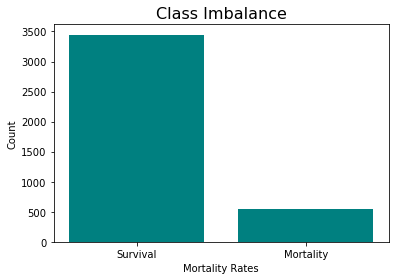

In [6]:
# before training, get an idea of class imbalance

oc_h2o['In-hospital_death'].table()

oc_pd = pd.DataFrame({'Outcome': ['Survival', 'Mortality'],
                     'Count': [3446, 554]})

oc_pd

plt.bar(oc_pd['Outcome'], oc_pd['Count'], color="teal")
plt.title('Class Imbalance', fontsize=16)
plt.xlabel('Mortality Rates')
plt.ylabel('Count')
plt.show()

## H2O
#### ML algorithm grid searches

In [7]:
gb_params = {
        'ntrees': [10,50,100], 
        'nfolds': [0, 3, 5],    
}

ranfor_params = {
        'ntrees': [5, 10, 50], 
        'nfolds': [0, 3, 5]  
}

dl_params = {
        'nfolds': [0, 3, 5],
        'train_samples_per_iteration': [100, 1100, 1500],
        'epochs': [5, 10]    
}

In [8]:
gb = H2OGradientBoostingEstimator()
ranfor = H2ORandomForestEstimator()
dl = H2ODeepLearningEstimator()

In [9]:
custom = H2OKFold(X_trainh2o, n_folds=5, seed=42)

In [10]:
# check the output types, dl needs to have real numbers

print(y_trainh2o.types)
print(y_traindl.types)

{'In-hospital_death': 'enum'}
{'In-hospital_death': 'real'}


In [11]:
# set up randomized search cv for each classifier
gbsearch = RandomizedSearchCV(gb, gb_params, n_iter=5,
                              scoring=make_scorer(h2o_r2_score),
                              cv=custom, random_state=42)
ransearch = RandomizedSearchCV(ranfor, ranfor_params, n_iter=5,
                              scoring=make_scorer(h2o_r2_score),
                              cv=custom, random_state=42)
dlsearch = RandomizedSearchCV(dl, dl_params, n_iter=5,
                              scoring=make_scorer(h2o_r2_score),
                              cv=custom, random_state=42)


In [12]:
# run randomized search cv for gb, ranfor, and dl estimators
gbsearch.fit(X_trainh2o, y_trainh2o)
ransearch.fit(X_trainh2o, y_trainh2o)
dlsearch.fit(X_trainh2o, y_traindl)

print('GB best: {}'.format(gbsearch.best_params_))
print('RF best: {}'.format(ransearch.best_params_))
print('DL best: {}'.format(dlsearch.best_params_))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm Model Build progress: |█

/Users/manny/opt/anaconda3/envs/py3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


deeplearning Model Build progress: |██████████████████████████████████████| 100%
GB best: {'nfolds': 5, 'ntrees': 50}
RF best: {'nfolds': 5, 'ntrees': 10}
DL best: {'nfolds': 5, 'train_samples_per_iteration': 1500, 'epochs': 5}


# Stacked Ensemble formation

In [13]:
x_t = X_h2o.columns

In [14]:
y_t = 'In-hospital_death'

In [15]:
# use best results from randomized search cv to create classifiers
# then create a stacked ensemble of the three

h2o_gb = H2OGradientBoostingEstimator(ntrees=50, nfolds=5,
                                    fold_assignment='modulo', seed=42,
                                     keep_cross_validation_predictions=True)

h2o_ranfor = H2ORandomForestEstimator(ntrees=10, nfolds=5, 
                                    fold_assignment='modulo', seed=42,
                                     keep_cross_validation_predictions=True)

h2o_deep = H2ODeepLearningEstimator(activation='tanh',
                                    nfolds=5, train_samples_per_iteration=1500, 
                                    fold_assignment='modulo', shuffle_training_data=True, 
                                    epochs=5, missing_values_handling='skip', 
                                    distribution='auto', seed=42, 
                                    keep_cross_validation_predictions=True)


# the 3 base models have to be trained prior to ensemble formation
h2o_gb.train(x=x_t, y=y_t, training_frame=full_train)
h2o_ranfor.train(x=x_t, y=y_t, training_frame=full_train)
h2o_deep.train(x=x_t, y=y_t, training_frame=full_train)

model_list = [h2o_gb, h2o_ranfor, h2o_deep]
stack = H2OStackedEnsembleEstimator(model_id='stackd', 
                                        base_models=model_list,
                                      metalearner_nfolds=5, seed=42)

stack.train(x=x_t, y=y_t, training_frame=full_train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [16]:
# check model performances on validation data and cross-validation

print(h2o_gb)
print(h2o_ranfor)
print(h2o_deep)
print(stack)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1641586441883_17691


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.02674127568566393
RMSE: 0.16352759915581203
LogLoss: 0.11849713879054585
Mean Per-Class Error: 0.02512142481588653
AUC: 0.9962101853451921
Gini: 0.9924203706903842
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6883768594495028: 


,IHD,SURVIVED,Error,Rate
IHD,394.0,28.0,0.0664,(28.0/422.0)
SURVIVED,5.0,2573.0,0.0019,(5.0/2578.0)
Total,399.0,2601.0,0.011,(33.0/3000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6883769,0.9936281,216.0
max f2,0.6405144,0.9963656,226.0
max f0point5,0.7860018,0.9921691,189.0
max accuracy,0.6883769,0.989,216.0
max precision,0.9882771,1.0,0.0
max recall,0.6036484,1.0,232.0
max specificity,0.9882771,1.0,0.0
max absolute_mcc,0.6883769,0.9539415,216.0
max min_per_class_accuracy,0.8089227,0.9728472,180.0
max mean_per_class_accuracy,0.7860018,0.9748786,189.0


Gains/Lift Table: Avg response rate: 85.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9872492,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0116369,16.3692785,16.3692785
,2,0.02,0.9862101,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0232739,16.3692785,16.3692785
,3,0.03,0.9858561,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0349108,16.3692785,16.3692785
,4,0.04,0.9853402,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0465477,16.3692785,16.3692785
,5,0.05,0.9847397,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0581846,16.3692785,16.3692785
,6,0.1,0.9826990,1.1636928,1.1636928,1.0,1.0,0.0581846,0.1163693,16.3692785,16.3692785
,7,0.15,0.9808122,1.1636928,1.1636928,1.0,1.0,0.0581846,0.1745539,16.3692785,16.3692785
,8,0.2,0.9784751,1.1636928,1.1636928,1.0,1.0,0.0581846,0.2327386,16.3692785,16.3692785
,9,0.3,0.9736407,1.1636928,1.1636928,1.0,1.0,0.1163693,0.3491078,16.3692785,16.3692785
,10,0.4,0.9667887,1.1636928,1.1636928,1.0,1.0,0.1163693,0.4654771,16.3692785,16.3692785




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.09638711045238138
RMSE: 0.3104627360125227
LogLoss: 0.3179296206806247
Mean Per-Class Error: 0.2497168899069413
AUC: 0.829267608896275
Gini: 0.6585352177925501
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39109799237213844: 


,IHD,SURVIVED,Error,Rate
IHD,80.0,342.0,0.8104,(342.0/422.0)
SURVIVED,34.0,2544.0,0.0132,(34.0/2578.0)
Total,114.0,2886.0,0.1253,(376.0/3000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3910980,0.9311859,328.0
max f2,0.1891872,0.9702448,372.0
max f0point5,0.6640238,0.9143501,243.0
max accuracy,0.3910980,0.8746667,328.0
max precision,0.9896871,1.0,0.0
max recall,0.0437003,1.0,396.0
max specificity,0.9896871,1.0,0.0
max absolute_mcc,0.6640238,0.4004773,243.0
max min_per_class_accuracy,0.9031377,0.7464455,117.0
max mean_per_class_accuracy,0.9362683,0.7502831,84.0


Gains/Lift Table: Avg response rate: 85.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9877627,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0116369,16.3692785,16.3692785
,2,0.02,0.9868343,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0232739,16.3692785,16.3692785
,3,0.03,0.9863829,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0349108,16.3692785,16.3692785
,4,0.04,0.9857215,1.1249030,1.1539953,0.9666667,0.9916667,0.0112490,0.0461598,12.4903026,15.3995345
,5,0.05,0.9851810,1.1636928,1.1559348,1.0,0.9933333,0.0116369,0.0577967,16.3692785,15.5934833
,6,0.1,0.9828953,1.1404189,1.1481769,0.98,0.9866667,0.0570209,0.1148177,14.0418929,14.8176881
,7,0.15,0.9805694,1.1636928,1.1533488,1.0,0.9911111,0.0581846,0.1730023,16.3692785,15.3348849
,8,0.2,0.9781718,1.1326610,1.1481769,0.9733333,0.9866667,0.0566330,0.2296354,13.2660978,14.8176881
,9,0.3,0.9723346,1.1404189,1.1455909,0.98,0.9844444,0.1140419,0.3436773,14.0418929,14.5590897
,10,0.4,0.9636050,1.1404189,1.1442979,0.98,0.9833333,0.1140419,0.4577192,14.0418929,14.4297905



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8823333,0.0145793,0.8883333,0.8983333,0.8416666,0.89,0.8933333
auc,0.8327455,0.0270294,0.8013635,0.8845645,0.7853628,0.8235501,0.8688865
err,0.1176667,0.0145793,0.1116667,0.1016667,0.1583333,0.11,0.1066667
err_count,70.6,8.747571,67.0,61.0,95.0,66.0,64.0
f0point5,0.9055179,0.0140439,0.9072022,0.9259948,0.8678261,0.9111738,0.9153928
f1,0.9353564,0.0079006,0.9399103,0.9422895,0.9130833,0.94,0.9414991
f2,0.9674803,0.0039637,0.9750651,0.9591680,0.9633204,0.9707097,0.9691382
lift_top_group,1.1640593,0.0147366,1.1450381,1.1695906,1.2024049,1.1516315,1.1516315
logloss,0.3179296,0.0339337,0.3229675,0.2806879,0.4081615,0.3006883,0.2771429
max_per_class_error,0.7739792,0.1005903,0.8815789,0.5287356,0.9405941,0.7848101,0.7341772


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2022-01-20 23:54:27,8.245 sec,0.0,0.3476774,0.4061718,0.5,1.0,0.1406667
,2022-01-20 23:54:27,8.285 sec,1.0,0.3347367,0.3747093,0.8498634,1.1371850,0.103
,2022-01-20 23:54:27,8.314 sec,2.0,0.3247467,0.3539815,0.8736299,1.1433112,0.095
,2022-01-20 23:54:27,8.351 sec,3.0,0.3153598,0.3358397,0.8937753,1.1466680,0.0863333
,2022-01-20 23:54:27,8.383 sec,4.0,0.3059853,0.3185884,0.9130264,1.1560285,0.0826667
---,---,---,---,---,---,---,---,---
,2022-01-20 23:54:29,9.794 sec,46.0,0.1700231,0.1253283,0.9955911,1.1636928,0.013
,2022-01-20 23:54:29,9.825 sec,47.0,0.1683167,0.1234279,0.9957602,1.1636928,0.0126667
,2022-01-20 23:54:29,9.865 sec,48.0,0.1662694,0.1213211,0.9960328,1.1636928,0.0116667
,2022-01-20 23:54:29,9.895 sec,49.0,0.1654487,0.1204066,0.9960337,1.1636928,0.012



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
GCS_last,182.2261047,1.0,0.1383337
BUN_q1,57.4661903,0.3153565,0.0436244
Age,39.2961273,0.2156449,0.0298310
WBC_last,30.9305801,0.1697374,0.0234804
BUN_min,26.2802219,0.1442177,0.0199502
---,---,---,---
Weight_q1,0.0,0.0,0.0
Weight_median,0.0,0.0,0.0
Weight_q3,0.0,0.0,0.0
Weight_mean,0.0,0.0,0.0



See the whole table with table.as_data_frame()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1641586441883_18259


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.13160135813150356
RMSE: 0.36276901484485075
LogLoss: 1.8388785002026542
Mean Per-Class Error: 0.33325771324863884
AUC: 0.6658418765280257
Gini: 0.33168375305605147
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


,IHD,SURVIVED,Error,Rate
IHD,0.0,418.0,1.0,(418.0/418.0)
SURVIVED,0.0,2552.0,0.0,(0.0/2552.0)
Total,0.0,2970.0,0.1407,(418.0/2970.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0,0.9243028,399.0
max f2,0.0,0.9682805,399.0
max f0point5,0.4807692,0.8941686,375.0
max accuracy,0.0,0.8592593,399.0
max precision,0.9913978,0.9224806,102.0
max recall,0.0,1.0,399.0
max specificity,1.0,0.7822967,0.0
max absolute_mcc,0.8419921,0.2469622,242.0
max min_per_class_accuracy,0.9862661,0.6578947,139.0
max mean_per_class_accuracy,0.8419921,0.6667423,242.0


Gains/Lift Table: Avg response rate: 85.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.2343333,1.0,1.0130583,1.0130583,0.8705548,0.8705548,0.2373933,0.2373933,1.3058299,1.3058299
,2,0.3003333,0.9987212,1.1460611,1.0422864,0.9848485,0.8956715,0.0756400,0.3130334,14.6061076,4.2286435
,3,0.401,0.9963431,1.1328665,1.0650256,0.9735099,0.9152120,0.1140419,0.4270753,13.2866486,6.5025566
,4,0.5,0.9935776,1.0970841,1.0713732,0.9427609,0.9206667,0.1086113,0.5356866,9.7084107,7.1373157
,5,0.601,0.9875717,1.0792002,1.0726885,0.9273927,0.9217970,0.1089992,0.6446858,7.9200240,7.2688524
,6,0.7,0.7993533,1.0030483,1.0628394,0.8619529,0.9133333,0.0993018,0.7439876,0.3048327,6.2839410
,7,0.821,0.6666667,0.9168489,1.0413231,0.7878788,0.8948437,0.1109387,0.8549263,-8.3151139,4.1323142
,8,0.9103333,0.5,0.8771117,1.0252087,0.7537313,0.8809960,0.0783553,0.9332816,-12.2888274,2.5208657
,9,1.0,0.0,0.7440712,1.0,0.6394052,0.8593333,0.0667184,1.0,-25.5928777,0.0




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.10576770402789012
RMSE: 0.3252194705547165
LogLoss: 0.5787477801811671
Mean Per-Class Error: 0.27792678846528596
AUC: 0.7633346692207855
Gini: 0.526669338441571
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3978142077103257: 


,IHD,SURVIVED,Error,Rate
IHD,33.0,389.0,0.9218,(389.0/422.0)
SURVIVED,19.0,2559.0,0.0074,(19.0/2578.0)
Total,52.0,2948.0,0.136,(408.0/3000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3978142,0.9261672,391.0
max f2,0.1000000,0.9683720,398.0
max f0point5,0.6478304,0.9028961,345.0
max accuracy,0.3978142,0.864,391.0
max precision,0.9212418,0.9606178,134.0
max recall,0.1000000,1.0,398.0
max specificity,1.0,0.9526066,0.0
max absolute_mcc,0.7841778,0.3326545,294.0
max min_per_class_accuracy,0.8333333,0.7051978,237.0
max mean_per_class_accuracy,0.8470588,0.7220732,235.0


Gains/Lift Table: Avg response rate: 85.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.1013333,1.0,1.0871340,1.0871340,0.9342105,0.9342105,0.1101629,0.1101629,8.7134049,8.7134049
,2,0.1646667,0.9998485,1.1146952,1.0977345,0.9578947,0.9433198,0.0705974,0.1807603,11.4695194,9.7734490
,3,0.2033333,0.9992271,1.1135336,1.1007389,0.9568966,0.9459016,0.0430566,0.2238169,11.3533613,10.0738913
,4,0.3013333,0.9985507,1.1280695,1.1096274,0.9693878,0.9535398,0.1105508,0.3343677,12.8069537,10.9627412
,5,0.4,0.9916925,1.1283102,1.1142358,0.9695946,0.9575,0.1113266,0.4456943,12.8310234,11.4235842
,6,0.5243333,0.9,1.0638586,1.1022901,0.9142091,0.9472346,0.1322731,0.5779674,6.3858552,10.2290051
,7,0.6003333,0.8977208,1.0769262,1.0990791,0.9254386,0.9444753,0.0818464,0.6598138,7.6926218,9.9079082
,8,0.715,0.8,0.9607231,1.0768905,0.8255814,0.9254079,0.1101629,0.7699767,-3.9276887,7.6890526
,9,0.8316667,0.7,0.9176549,1.0545529,0.7885714,0.9062124,0.1070597,0.8770365,-8.2345118,5.4552861
,10,0.9096667,0.6,0.8304987,1.0353412,0.7136752,0.8897032,0.0647789,0.9418154,-16.9501303,3.5341181



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.865,0.0137437,0.885,0.855,0.8316666,0.8783333,0.875
auc,0.7664168,0.0320851,0.7177456,0.8073648,0.7096074,0.7770111,0.8203552
err,0.135,0.0137437,0.115,0.145,0.1683333,0.1216667,0.125
err_count,81.0,8.246211,69.0,87.0,101.0,73.0,75.0
f0point5,0.8894266,0.0118300,0.9054709,0.8805355,0.8606416,0.9007289,0.8997564
f1,0.9269425,0.0076784,0.9381166,0.9218329,0.9080983,0.9342934,0.9323715
f2,0.9678779,0.0028583,0.9732043,0.9671946,0.9610940,0.9704562,0.9674401
lift_top_group,1.0519994,0.0528065,0.9368494,1.0526316,1.0115469,1.107338,1.1516315
logloss,0.5787478,0.1666190,0.5072891,0.4062243,0.9776883,0.6904622,0.3120749
max_per_class_error,0.9384410,0.0355561,0.8947368,1.0,1.0,0.8987342,0.8987342


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2022-01-20 23:54:31,1.819 sec,0.0,nan,nan,nan,nan,nan
,2022-01-20 23:54:31,1.843 sec,1.0,0.4219241,6.1485923,0.6177878,1.0327773,0.1462307
,2022-01-20 23:54:31,1.865 sec,2.0,0.4153830,5.6639873,0.6334092,1.0424908,0.1421433
,2022-01-20 23:54:31,1.888 sec,3.0,0.4138867,4.8460887,0.6509861,1.0519179,0.1427936
,2022-01-20 23:54:31,1.912 sec,4.0,0.4154810,4.5330960,0.6018491,1.0245996,0.1426314
,2022-01-20 23:54:32,1.937 sec,5.0,0.4055496,4.0181099,0.6215953,1.0339721,0.1433837
,2022-01-20 23:54:32,1.968 sec,6.0,0.3917920,3.4161992,0.6313188,1.0338387,0.1418919
,2022-01-20 23:54:32,1.996 sec,7.0,0.3819080,2.9061172,0.6367507,1.0301080,0.1418118
,2022-01-20 23:54:32,2.023 sec,8.0,0.3748050,2.4510015,0.6541185,1.0346387,0.1401645
,2022-01-20 23:54:32,2.049 sec,9.0,0.3668579,2.0826889,0.6590483,1.0236187,0.1403330


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
BUN_q3,49.9325905,1.0,0.0217373
GCS_q3,45.3985252,0.9091963,0.0197635
GCS_last,38.2876434,0.7667866,0.0166679
GCS_max,37.9446487,0.7599175,0.0165186
BUN_mean,31.9789734,0.6404429,0.0139215
---,---,---,---
AST_mean,0.0,0.0,0.0
Cholesterol_first,0.0,0.0,0.0
Cholesterol_count,0.0,0.0,0.0
Creatinine_mean,0.0,0.0,0.0



See the whole table with table.as_data_frame()

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1641586441883_18381


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.01355222245221895
RMSE: 0.11641401312650874
LogLoss: 0.05450213657039132
Mean Per-Class Error: 0.02824574691428383
AUC: 0.9960502465263863
Gini: 0.9921004930527726
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4603792371592076: 


,IHD,SURVIVED,Error,Rate
IHD,390.0,32.0,0.0758,(32.0/422.0)
SURVIVED,11.0,2567.0,0.0043,(11.0/2578.0)
Total,401.0,2599.0,0.0143,(43.0/3000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4603792,0.9916940,249.0
max f2,0.2778167,0.9956727,275.0
max f0point5,0.6805631,0.9911567,210.0
max accuracy,0.4603792,0.9856667,249.0
max precision,0.9999834,1.0,0.0
max recall,0.1394593,1.0,311.0
max specificity,0.9999834,1.0,0.0
max absolute_mcc,0.4603792,0.9398634,249.0
max min_per_class_accuracy,0.7844576,0.9668246,183.0
max mean_per_class_accuracy,0.7110300,0.9717543,202.0


Gains/Lift Table: Avg response rate: 85.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9999957,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0116369,16.3692785,16.3692785
,2,0.02,0.9999922,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0232739,16.3692785,16.3692785
,3,0.03,0.9999875,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0349108,16.3692785,16.3692785
,4,0.04,0.9999816,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0465477,16.3692785,16.3692785
,5,0.05,0.9999771,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0581846,16.3692785,16.3692785
,6,0.1,0.9999363,1.1636928,1.1636928,1.0,1.0,0.0581846,0.1163693,16.3692785,16.3692785
,7,0.15,0.9998604,1.1636928,1.1636928,1.0,1.0,0.0581846,0.1745539,16.3692785,16.3692785
,8,0.2,0.9997487,1.1636928,1.1636928,1.0,1.0,0.0581846,0.2327386,16.3692785,16.3692785
,9,0.3,0.9993068,1.1636928,1.1636928,1.0,1.0,0.1163693,0.3491078,16.3692785,16.3692785
,10,0.4,0.9983119,1.1636928,1.1636928,1.0,1.0,0.1163693,0.4654771,16.3692785,16.3692785




ModelMetricsBinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.12803899646275188
RMSE: 0.3578253714631648
LogLoss: 0.544980587142951
Mean Per-Class Error: 0.31306369241742926
AUC: 0.7493400225752723
Gini: 0.49868004515054465
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0318980740932648: 


,IHD,SURVIVED,Error,Rate
IHD,35.0,387.0,0.9171,(387.0/422.0)
SURVIVED,18.0,2560.0,0.007,(18.0/2578.0)
Total,53.0,2947.0,0.135,(405.0/3000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0318981,0.9266968,385.0
max f2,0.0031936,0.9687242,397.0
max f0point5,0.6262437,0.9016393,219.0
max accuracy,0.0318981,0.865,385.0
max precision,0.9997430,0.9650794,1.0
max recall,0.0013566,1.0,398.0
max specificity,0.9999339,0.9549763,0.0
max absolute_mcc,0.6262437,0.2977413,219.0
max min_per_class_accuracy,0.9794068,0.6714507,44.0
max mean_per_class_accuracy,0.9924654,0.6869363,23.0


Gains/Lift Table: Avg response rate: 85.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9999973,1.1249030,1.1249030,0.9666667,0.9666667,0.0112490,0.0112490,12.4903026,12.4903026
,2,0.02,0.9999946,1.1636928,1.1442979,1.0,0.9833333,0.0116369,0.0228860,16.3692785,14.4297905
,3,0.03,0.9999901,1.1636928,1.1507629,1.0,0.9888889,0.0116369,0.0345229,16.3692785,15.0762865
,4,0.04,0.9999845,1.0861133,1.1346005,0.9333333,0.975,0.0108611,0.0453840,8.6113266,13.4600465
,5,0.05,0.9999795,1.1249030,1.1326610,0.9666667,0.9733333,0.0112490,0.0566330,12.4903026,13.2660978
,6,0.1,0.9999397,1.1249030,1.1287820,0.9666667,0.97,0.0562452,0.1128782,12.4903026,12.8782002
,7,0.15,0.9998668,1.1326610,1.1300750,0.9733333,0.9711111,0.0566330,0.1695112,13.2660978,13.0074994
,8,0.2,0.9997214,1.1016292,1.1229635,0.9466667,0.965,0.0550815,0.2245927,10.1629170,12.2963538
,9,0.3,0.9991657,1.1210240,1.1223170,0.9633333,0.9644444,0.1121024,0.3366951,12.1024050,12.2317042
,10,0.4,0.9975210,1.0899922,1.1142358,0.9366667,0.9575,0.1089992,0.4456943,8.9992242,11.4235842



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8696667,0.0096148,0.885,0.8633333,0.8466667,0.8733333,0.88
auc,0.7539112,0.0363120,0.743986,0.8160247,0.6889422,0.7106708,0.8099322
err,0.1303333,0.0096148,0.115,0.1366667,0.1533333,0.1266667,0.12
err_count,78.2,5.7688823,69.0,82.0,92.0,76.0,72.0
f0point5,0.8926353,0.0083428,0.9070334,0.8873484,0.8728486,0.8954967,0.9004493
f1,0.9292855,0.0057125,0.9378938,0.925859,0.9152855,0.9320214,0.9353681
f2,0.9691216,0.0027746,0.9709281,0.9678639,0.9620596,0.9716524,0.9731042
lift_top_group,1.0858113,0.0632686,0.9541985,1.1695906,1.002004,1.1516315,1.1516315
logloss,0.5449806,0.0718992,0.5045521,0.4871440,0.73652,0.5516259,0.4450609
max_per_class_error,0.9127924,0.0228001,0.8684211,0.9310345,0.8910891,0.9620253,0.9113924


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2022-01-20 23:55:07,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan
,2022-01-20 23:55:07,35.437 sec,2322 obs/sec,0.507,1,1521.0,0.3415279,0.5251231,0.7737160,1.1636928,0.1303333
,2022-01-20 23:55:12,40.552 sec,2175 obs/sec,4.0176667,8,12053.0,0.1790214,0.1117056,0.9810647,1.1636928,0.0423333
,2022-01-20 23:55:15,42.757 sec,2192 obs/sec,5.522,11,16566.0,0.1164140,0.0545021,0.9960502,1.1636928,0.0143333


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
pH_median,1.0,1.0,0.0036701
Temp_min,0.9716519,0.9716519,0.0035660
PaO2_max,0.9694641,0.9694641,0.0035580
GCS_last,0.9640965,0.9640965,0.0035383
Age,0.9565830,0.9565830,0.0035107
---,---,---,---
Creatinine_median,0.7451272,0.7451272,0.0027347
Bilirubin_mean,0.7446607,0.7446607,0.0027330
ALP_last,0.7360801,0.7360801,0.0027015
Bilirubin_max,0.7274420,0.7274420,0.0026698



See the whole table with table.as_data_frame()

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  stackd
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.015607236316764514
RMSE: 0.12492892506046994
LogLoss: 0.10075309457693868
Null degrees of freedom: 2999
Residual degrees of freedom: 2996
Null deviance: 2437.0310107335326
Residual deviance: 604.5185674616321
AIC: 612.5185674616321
AUC: 0.9998478742844117
Gini: 0.9996957485688234
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7410071730063791: 


,IHD,SURVIVED,Error,Rate
IHD,414.0,8.0,0.019,(8.0/422.0)
SURVIVED,3.0,2575.0,0.0012,(3.0/2578.0)
Total,417.0,2583.0,0.0037,(11.0/3000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.7410072,0.9978686,183.0
max f2,0.6640139,0.9988377,191.0
max f0point5,0.7808745,0.9985219,173.0
max accuracy,0.7410072,0.9963333,183.0
max precision,0.9497373,1.0,0.0
max recall,0.6640139,1.0,191.0
max specificity,0.9497373,1.0,0.0
max absolute_mcc,0.7410072,0.9847815,183.0
max min_per_class_accuracy,0.7808745,0.9952607,173.0
max mean_per_class_accuracy,0.7808745,0.9954969,173.0


Gains/Lift Table: Avg response rate: 85.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9495404,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0116369,16.3692785,16.3692785
,2,0.02,0.9493785,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0232739,16.3692785,16.3692785
,3,0.03,0.9492385,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0349108,16.3692785,16.3692785
,4,0.04,0.9491625,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0465477,16.3692785,16.3692785
,5,0.05,0.9490592,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0581846,16.3692785,16.3692785
,6,0.1,0.9486648,1.1636928,1.1636928,1.0,1.0,0.0581846,0.1163693,16.3692785,16.3692785
,7,0.15,0.9482599,1.1636928,1.1636928,1.0,1.0,0.0581846,0.1745539,16.3692785,16.3692785
,8,0.2,0.9478316,1.1636928,1.1636928,1.0,1.0,0.0581846,0.2327386,16.3692785,16.3692785
,9,0.3,0.9465716,1.1636928,1.1636928,1.0,1.0,0.1163693,0.3491078,16.3692785,16.3692785
,10,0.4,0.9446136,1.1636928,1.1636928,1.0,1.0,0.1163693,0.4654771,16.3692785,16.3692785




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.09669633896578192
RMSE: 0.31096034950742824
LogLoss: 0.3235515682978596
Null degrees of freedom: 2999
Residual degrees of freedom: 2996
Null deviance: 2438.441363495571
Residual deviance: 1941.3094097871578
AIC: 1949.3094097871578
AUC: 0.8246569588093198
Gini: 0.6493139176186395
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29875852011040976: 


,IHD,SURVIVED,Error,Rate
IHD,62.0,360.0,0.8531,(360.0/422.0)
SURVIVED,20.0,2558.0,0.0078,(20.0/2578.0)
Total,82.0,2918.0,0.1267,(380.0/3000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2987585,0.9308588,348.0
max f2,0.1033168,0.9691001,390.0
max f0point5,0.7774725,0.9166536,185.0
max accuracy,0.3004287,0.8733333,347.0
max precision,0.9519018,1.0,0.0
max recall,0.1033168,1.0,390.0
max specificity,0.9519018,1.0,0.0
max absolute_mcc,0.7278493,0.4091137,214.0
max min_per_class_accuracy,0.8971227,0.7370054,92.0
max mean_per_class_accuracy,0.9104082,0.7404239,77.0


Gains/Lift Table: Avg response rate: 85.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9516640,1.1636928,1.1636928,1.0,1.0,0.0116369,0.0116369,16.3692785,16.3692785
,2,0.02,0.9512050,1.1249030,1.1442979,0.9666667,0.9833333,0.0112490,0.0228860,12.4903026,14.4297905
,3,0.03,0.9505484,1.1636928,1.1507629,1.0,0.9888889,0.0116369,0.0345229,16.3692785,15.0762865
,4,0.04,0.9501150,1.1636928,1.1539953,1.0,0.9916667,0.0116369,0.0461598,16.3692785,15.3995345
,5,0.05,0.9497908,1.0861133,1.1404189,0.9333333,0.98,0.0108611,0.0570209,8.6113266,14.0418929
,6,0.1,0.9487965,1.1559348,1.1481769,0.9933333,0.9866667,0.0577967,0.1148177,15.5934833,14.8176881
,7,0.15,0.9481412,1.1636928,1.1533488,1.0,0.9911111,0.0581846,0.1730023,16.3692785,15.3348849
,8,0.2,0.9475134,1.1481769,1.1520559,0.9866667,0.99,0.0574088,0.2304112,14.8176881,15.2055857
,9,0.3,0.9448217,1.1404189,1.1481769,0.98,0.9866667,0.1140419,0.3444531,14.0418929,14.8176881
,10,0.4,0.9369227,1.1055081,1.1375097,0.95,0.9775,0.1105508,0.4550039,10.5508146,13.7509697


## Model Evaluation
#### Evaluate each model based on predictions on test set

In [17]:
# run predictions on each of the models

h2o_gb.predict(full_test)
h2o_ranfor.predict(full_test)
h2o_deep.predict(full_test)
stack.predict(full_test)

gbm prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,IHD,SURVIVED
SURVIVED,0.0526427,0.947357
SURVIVED,0.0757352,0.924265
SURVIVED,0.0529083,0.947092
SURVIVED,0.104682,0.895318
SURVIVED,0.0558332,0.944167
SURVIVED,0.0521505,0.947849
SURVIVED,0.0516474,0.948353
SURVIVED,0.112195,0.887805
SURVIVED,0.301159,0.698841
SURVIVED,0.0879296,0.91207


In [18]:
print(h2o_gb.model_performance(full_test))
print(h2o_ranfor.model_performance(full_test))
print(h2o_deep.model_performance(full_test))
print(stack.model_performance(full_test))


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.08883893803869193
RMSE: 0.2980586151056398
LogLoss: 0.29051643096339697
Mean Per-Class Error: 0.22238514173998047
AUC: 0.8561915235302333
Gini: 0.7123830470604666
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30728307590469456: 


,IHD,SURVIVED,Error,Rate
IHD,25.0,107.0,0.8106,(107.0/132.0)
SURVIVED,7.0,861.0,0.0081,(7.0/868.0)
Total,32.0,968.0,0.114,(114.0/1000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3072831,0.9379085,368.0
max f2,0.2210239,0.9719416,382.0
max f0point5,0.8067236,0.9256098,240.0
max accuracy,0.3072831,0.886,368.0
max precision,0.9893646,1.0,0.0
max recall,0.1161669,1.0,397.0
max specificity,0.9893646,1.0,0.0
max absolute_mcc,0.8067236,0.4324555,240.0
max min_per_class_accuracy,0.8898394,0.7651515,174.0
max mean_per_class_accuracy,0.9305337,0.7776149,124.0


Gains/Lift Table: Avg response rate: 86.80 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9867969,1.1520737,1.1520737,1.0,1.0,0.0115207,0.0115207,15.2073733,15.2073733
,2,0.02,0.9862988,1.1520737,1.1520737,1.0,1.0,0.0115207,0.0230415,15.2073733,15.2073733
,3,0.03,0.9857693,1.1520737,1.1520737,1.0,1.0,0.0115207,0.0345622,15.2073733,15.2073733
,4,0.04,0.9848344,1.1520737,1.1520737,1.0,1.0,0.0115207,0.0460829,15.2073733,15.2073733
,5,0.05,0.9843109,1.1520737,1.1520737,1.0,1.0,0.0115207,0.0576037,15.2073733,15.2073733
,6,0.1,0.9815790,1.1520737,1.1520737,1.0,1.0,0.0576037,0.1152074,15.2073733,15.2073733
,7,0.15,0.9795942,1.1520737,1.1520737,1.0,1.0,0.0576037,0.1728111,15.2073733,15.2073733
,8,0.2,0.9772857,1.1059908,1.1405530,0.96,0.99,0.0552995,0.2281106,10.5990783,14.0552995
,9,0.3,0.9713538,1.1520737,1.1443932,1.0,0.9933333,0.1152074,0.3433180,15.2073733,14.4393241
,10,0.4,0.9604434,1.1290323,1.1405530,0.98,0.99,0.1129032,0.4562212,12.9032258,14.0552995





ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.10059442020081259
RMSE: 0.3171662343327432
LogLoss: 0.34472661426998447
Mean Per-Class Error: 0.26340594888981994
AUC: 0.7861855886049435
Gini: 0.572371177209887
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32499999999999996: 


,IHD,SURVIVED,Error,Rate
IHD,15.0,117.0,0.8864,(117.0/132.0)
SURVIVED,9.0,859.0,0.0104,(9.0/868.0)
Total,24.0,976.0,0.126,(126.0/1000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3250000,0.9316703,339.0
max f2,0.2000000,0.9707001,343.0
max f0point5,0.6959805,0.9119718,302.0
max accuracy,0.3975000,0.874,335.0
max precision,1.0,1.0,0.0
max recall,0.2000000,1.0,343.0
max specificity,1.0,1.0,0.0
max absolute_mcc,0.7294088,0.3588655,288.0
max min_per_class_accuracy,0.8256588,0.7096774,236.0
max mean_per_class_accuracy,0.8861601,0.7365941,226.0


Gains/Lift Table: Avg response rate: 86.80 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.013,0.9997050,1.1520737,1.1520737,1.0,1.0,0.0149770,0.0149770,15.2073733,15.2073733
,2,0.031,0.9993154,1.1520737,1.1520737,1.0,1.0,0.0207373,0.0357143,15.2073733,15.2073733
,3,0.045,0.9985612,1.1520737,1.1520737,1.0,1.0,0.0161290,0.0518433,15.2073733,15.2073733
,4,0.053,0.9982662,1.1520737,1.1520737,1.0,1.0,0.0092166,0.0610599,15.2073733,15.2073733
,5,0.115,0.9978766,1.1149101,1.1320377,0.9677419,0.9826087,0.0691244,0.1301843,11.4910064,13.2037668
,6,0.179,0.9969957,1.0620680,1.1070206,0.921875,0.9608939,0.0679724,0.1981567,6.2067972,10.7020570
,7,0.209,0.9964681,1.1520737,1.1134875,1.0,0.9665072,0.0345622,0.2327189,15.2073733,11.3487531
,8,0.313,0.9951351,1.1409961,1.1226278,0.9903846,0.9744409,0.1186636,0.3513825,14.0996101,12.2627759
,9,0.4,0.9871403,1.0991048,1.1175115,0.9540230,0.97,0.0956221,0.4470046,9.9104825,11.7511521
,10,0.5,0.8975072,1.0714286,1.1082949,0.93,0.962,0.1071429,0.5541475,7.1428571,10.8294931





ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.11940155254320976
RMSE: 0.3455452973825715
LogLoss: 0.4692313621481966
Mean Per-Class Error: 0.2862554112554112
AUC: 0.7812849113252339
Gini: 0.5625698226504678
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.04704682073897064: 


,IHD,SURVIVED,Error,Rate
IHD,16.0,116.0,0.8788,(116.0/132.0)
SURVIVED,4.0,864.0,0.0046,(4.0/868.0)
Total,20.0,980.0,0.12,(120.0/1000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0470468,0.9350649,383.0
max f2,0.0032534,0.9711345,398.0
max f0point5,0.5455000,0.9074410,295.0
max accuracy,0.0470468,0.88,383.0
max precision,0.9999896,1.0,0.0
max recall,0.0032534,1.0,398.0
max specificity,0.9999896,1.0,0.0
max absolute_mcc,0.1336801,0.2991825,368.0
max min_per_class_accuracy,0.9757596,0.6900922,93.0
max mean_per_class_accuracy,0.9932272,0.7137446,47.0


Gains/Lift Table: Avg response rate: 86.80 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9999950,1.1520737,1.1520737,1.0,1.0,0.0115207,0.0115207,15.2073733,15.2073733
,2,0.02,0.9999922,1.1520737,1.1520737,1.0,1.0,0.0115207,0.0230415,15.2073733,15.2073733
,3,0.03,0.9999862,1.1520737,1.1520737,1.0,1.0,0.0115207,0.0345622,15.2073733,15.2073733
,4,0.04,0.9999790,1.1520737,1.1520737,1.0,1.0,0.0115207,0.0460829,15.2073733,15.2073733
,5,0.05,0.9999673,1.1520737,1.1520737,1.0,1.0,0.0115207,0.0576037,15.2073733,15.2073733
,6,0.1,0.9999160,1.1520737,1.1520737,1.0,1.0,0.0576037,0.1152074,15.2073733,15.2073733
,7,0.15,0.9998458,1.1520737,1.1520737,1.0,1.0,0.0576037,0.1728111,15.2073733,15.2073733
,8,0.2,0.9997251,1.1520737,1.1520737,1.0,1.0,0.0576037,0.2304147,15.2073733,15.2073733
,9,0.3,0.9992209,1.0829493,1.1290323,0.94,0.98,0.1082949,0.3387097,8.2949309,12.9032258
,10,0.4,0.9977109,1.0944700,1.1203917,0.95,0.9725,0.1094470,0.4481567,9.4470046,12.0391705





ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.09046125192902742
RMSE: 0.3007677707618079
LogLoss: 0.30452902417856886
Null degrees of freedom: 999
Residual degrees of freedom: 996
Null deviance: 780.9744298404923
Residual deviance: 609.0580483571377
AIC: 617.0580483571377
AUC: 0.8437456360843457
Gini: 0.6874912721686914
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5218030868805117: 


,IHD,SURVIVED,Error,Rate
IHD,42.0,90.0,0.6818,(90.0/132.0)
SURVIVED,24.0,844.0,0.0276,(24.0/868.0)
Total,66.0,934.0,0.114,(114.0/1000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5218031,0.9367370,335.0
max f2,0.2352050,0.9712553,381.0
max f0point5,0.8305859,0.9235905,217.0
max accuracy,0.5218031,0.886,335.0
max precision,0.9496599,1.0,0.0
max recall,0.0908813,1.0,396.0
max specificity,0.9496599,1.0,0.0
max absolute_mcc,0.8757660,0.4232524,176.0
max min_per_class_accuracy,0.8906113,0.7727273,155.0
max mean_per_class_accuracy,0.8878502,0.7769166,159.0


Gains/Lift Table: Avg response rate: 86.80 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9495131,1.1520737,1.1520737,1.0,1.0,0.0115207,0.0115207,15.2073733,15.2073733
,2,0.02,0.9494369,1.1520737,1.1520737,1.0,1.0,0.0115207,0.0230415,15.2073733,15.2073733
,3,0.03,0.9492162,1.1520737,1.1520737,1.0,1.0,0.0115207,0.0345622,15.2073733,15.2073733
,4,0.04,0.9490741,1.1520737,1.1520737,1.0,1.0,0.0115207,0.0460829,15.2073733,15.2073733
,5,0.05,0.9489716,1.1520737,1.1520737,1.0,1.0,0.0115207,0.0576037,15.2073733,15.2073733
,6,0.1,0.9485321,1.1520737,1.1520737,1.0,1.0,0.0576037,0.1152074,15.2073733,15.2073733
,7,0.15,0.9479231,1.1290323,1.1443932,0.98,0.9933333,0.0564516,0.1716590,12.9032258,14.4393241
,8,0.2,0.9472246,1.1520737,1.1463134,1.0,0.995,0.0576037,0.2292627,15.2073733,14.6313364
,9,0.3,0.9443562,1.1405530,1.1443932,0.99,0.9933333,0.1140553,0.3433180,14.0552995,14.4393241
,10,0.4,0.9358360,1.0829493,1.1290323,0.94,0.98,0.1082949,0.4516129,8.2949309,12.9032258
